In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/TSAI_EVA_4.0/TSAI

/content/gdrive/My Drive/TSAI_EVA_4.0/TSAI


In [3]:
import albumentations # to apply image augmentation using albumentations library.
print(albumentations.__version__) # check verison

# this is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install -U git+https://github.com/albu/albumentations # --no-cache-dir

0.4.5


In [0]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CyclicLR, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:

# Load standard packages

from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CyclicLR, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import pkgutil
import importlib

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("apex module does not exist")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

from utils.lr_finder import LRFinder # cutom module for LR finder


apex module does not exist
  Cloning https://www.github.com/NVIDIA/apex to /tmp/pip-req-build-5s8d4bai
  Running command git clone -q https://www.github.com/NVIDIA/apex /tmp/pip-req-build-5s8d4bai
  Running command git submodule update --init --recursive -q
  Created wheel for apex: filename=apex-0.1-cp36-none-any.whl size=153170 sha256=4a12772ef72ff61730a8b9576edbfdc3859ae5e147f021c90d7a3a449682bf3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-tog42302/wheels/08/3e/36/a75a9914e497fe42598f9dbe67496b2b300a8851f4d396a285
Successfully built apex


In [0]:
# load custom python packages
import utils.common_utils as cutils          # common utililies fxn
import utils.model_utils as mutils           # utilities for basic conv block, depthwise seperable blocks, train, test, build fucntions
import utils.model_history as model_history  # utilitie for storing and visualizing model results
from utils.plot_utils import PlotUtils       # utilities for ploting images, model history, misclassified images etc
#import models.cifar10_net_cnn as cifar10_net_cnn  # CIFAR10 network design using custom CNN network
import model.resnet as resnet                    # resnet model

import utils.albumentations as album_utils # utilities fxn based on albumentations
import gradcam.gradcam_abs as gradcamAbs 

In [8]:
# check GPU availability and use cuda to get GPU device
cuda, device = cutils.get_device()

CUDA Available? True
Device:  cuda:0


In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

config_params = dict(
    seed=1,
    batch_size=128,
    num_workers=4,
    epochs=50
)

# For reproducibility
torch.manual_seed(config_params["seed"])

if cuda:
    torch.cuda.manual_seed(config_params["seed"])

In [10]:
means, stds = album_utils.calculate_dataset_mean_std()
print("means: {}".format(means))
print("stds: {}".format(stds))

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Total dataset(train+test) shape:  (60000, 32, 32, 3)
means: [0.49186864, 0.48265335, 0.44717798]
stds: [0.24697131, 0.24338901, 0.26159254]


In [11]:
# fill values for cutout portion
fill_value = [255. * mean for mean in means]

# to apply specific augmentation, set apply=True
# augmentaion is ignore is either apply=False or speific a attribute is missing
albumentations_args = dict(
            GeneralParams=dict(input_size=32),            
            RandomCrop=dict(apply=False, size=8, p=0.20),
            HorizontalFlip=dict(apply=True, p=0.7),
            ElasticTransform=dict(apply=False, sigma=50, alpha=1, alpha_affine=10, p=0.10),
            CoarseDropout=dict(apply=True, max_holes=1, max_height=16, max_width=16, min_height=4, min_width=4, fill_value=fill_value, p=0.70),
            Normalize=dict(apply=True, means=means, stds=stds))

albumentations_args

{'CoarseDropout': {'apply': True,
  'fill_value': [125.42650446295738, 123.07660415768623, 114.03038397431374],
  'max_height': 16,
  'max_holes': 1,
  'max_width': 16,
  'min_height': 4,
  'min_width': 4,
  'p': 0.7},
 'ElasticTransform': {'alpha': 1,
  'alpha_affine': 10,
  'apply': False,
  'p': 0.1,
  'sigma': 50},
 'GeneralParams': {'input_size': 32},
 'HorizontalFlip': {'apply': True, 'p': 0.7},
 'Normalize': {'apply': True,
  'means': [0.49186864, 0.48265335, 0.44717798],
  'stds': [0.24697131, 0.24338901, 0.26159254]},
 'RandomCrop': {'apply': False, 'p': 0.2, 'size': 8}}

In [12]:
train_transforms, test_transforms = album_utils.get_data_transform(albumentations_args)

CoarseDropout/Cutout is enabled
HorizontalFlip is enabled


In [13]:
# load data
train_loader, test_loader = album_utils.get_dataloader(train_transforms, test_transforms, 
                                                       batch_size=config_params["batch_size"], num_workers=config_params["num_workers"])

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


In [0]:
# create PlotUtils class instance
putils = PlotUtils(device, classes, means, stds)

FileNotFoundError: ignored

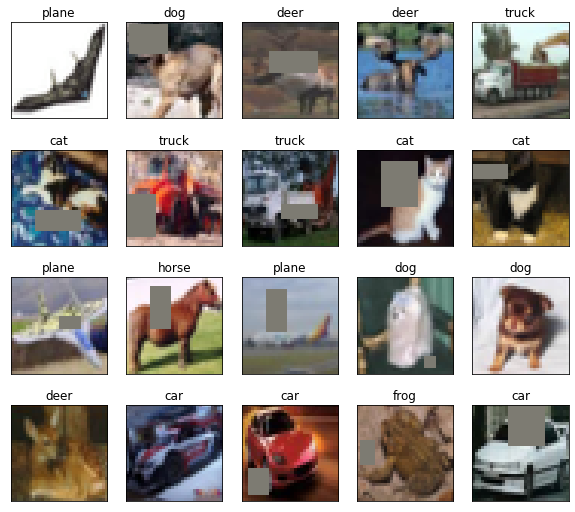

In [15]:
# visualize how image aumentation is applied on few training dataset images: 
putils.plot_dataset_images(train_loader, save_filename="albumentations_images")

In [16]:
# Create CIFAR10 network
model = resnet.ResNet18()
mutils.model_summary(model, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
        BasicBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
          Dropout-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
       BasicBlock-14           [-1, 64,

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=1e-3)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=200, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


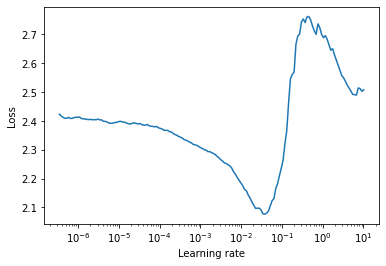

In [18]:
# Note that the loss in the loss vs. learning rate plot is the training loss.
lr_finder.plot()

In [19]:
# To restore the model and optimizer to their initial state
lr_finder.reset()
'''
Here model is evaluated on that validation dataset after each iteration.
The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. 
The disadvantage is that it takes significantly longer to run
'''
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=150, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


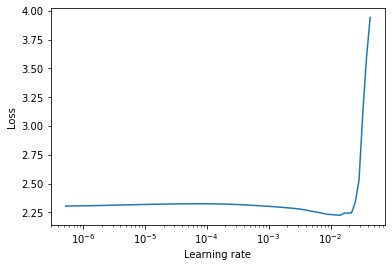

In [20]:
# Note that the loss in the loss vs. learning rate plot is the validation loss.
lr_finder.plot()

In [21]:
model_name = "CIFAR10 Resnet18"
model =  model.to(device)
EPOCHS = config_params["epochs"]

start_lr = 1e-4 # minimum LR as per LRFinder result
end_lr = 5e-2   # maximu LR as per LRFinder result
step_size = 6   # stepsize for Lr cycle policy

#criterion = F.nll_loss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)  # using L2 Regulaization

# CyclicLR-Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=start_lr, max_lr=end_lr, step_size_up=step_size, mode='triangular2')
#lr_scheduler = MultiStepLR(optimizer, milestones=[8,16,24], gamma=0.3)
#lr_scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

# reduce LR when modle get stuck in plateu region
reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.001)

model_history = mutils.build_model(model, 
                            device, 
                            trainloader=train_loader, 
                            testloader=test_loader, 
                            epochs=EPOCHS,
                            criterion=criterion, 
                            optimizer=optimizer,
                            lr_scheduler=lr_scheduler,
                            reduceLr_scheduler=reduceLr_scheduler,
                            L1_loss_enable=True)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH-1: learning rate is: 0.0001


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.829274, Accuracy: 3182/10000 (31.82%)

EPOCH-2: learning rate is: 0.008416666666666659


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.168957, Accuracy: 5910/10000 (59.10%)

EPOCH-3: learning rate is: 0.01673333333333334


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.886058, Accuracy: 6882/10000 (68.82%)

EPOCH-4: learning rate is: 0.02505


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.918145, Accuracy: 6919/10000 (69.19%)

EPOCH-5: learning rate is: 0.03336666666666666


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.927421, Accuracy: 7143/10000 (71.43%)

EPOCH-6: learning rate is: 0.04168333333333334


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.663410, Accuracy: 7804/10000 (78.04%)

EPOCH-7: learning rate is: 0.05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.680717, Accuracy: 7735/10000 (77.35%)

EPOCH-8: learning rate is: 0.04168333333333332


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.644625, Accuracy: 7925/10000 (79.25%)

EPOCH-9: learning rate is: 0.03336666666666668


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.489039, Accuracy: 8306/10000 (83.06%)

EPOCH-10: learning rate is: 0.02505


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.517890, Accuracy: 8300/10000 (83.00%)

EPOCH-11: learning rate is: 0.01673333333333332


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.500283, Accuracy: 8371/10000 (83.71%)

EPOCH-12: learning rate is: 0.008416666666666682


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.358507, Accuracy: 8775/10000 (87.75%)

EPOCH-13: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.319351, Accuracy: 8895/10000 (88.95%)

EPOCH-14: learning rate is: 0.004258333333333319


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.325146, Accuracy: 8909/10000 (89.09%)

EPOCH-15: learning rate is: 0.008416666666666682


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.360713, Accuracy: 8804/10000 (88.04%)

EPOCH-16: learning rate is: 0.012575


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.410206, Accuracy: 8656/10000 (86.56%)

EPOCH-17: learning rate is: 0.01673333333333332


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.444656, Accuracy: 8549/10000 (85.49%)

EPOCH-18: learning rate is: 0.02089166666666668


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.514681, Accuracy: 8277/10000 (82.77%)

EPOCH-19: learning rate is: 0.0025050000000000003


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.296219, Accuracy: 8984/10000 (89.84%)

EPOCH-20: learning rate is: 0.02089166666666668


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.486058, Accuracy: 8395/10000 (83.95%)

EPOCH-21: learning rate is: 0.01673333333333332


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.493626, Accuracy: 8409/10000 (84.09%)

EPOCH-22: learning rate is: 0.012575


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.433943, Accuracy: 8602/10000 (86.02%)

EPOCH-23: learning rate is: 0.008416666666666682


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.377685, Accuracy: 8818/10000 (88.18%)

EPOCH-24: learning rate is: 0.004258333333333319


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.309693, Accuracy: 9005/10000 (90.05%)

EPOCH-25: learning rate is: 1e-05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.297233, Accuracy: 9040/10000 (90.40%)

EPOCH-26: learning rate is: 0.0021791666666666704


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.286860, Accuracy: 9062/10000 (90.62%)

EPOCH-27: learning rate is: 0.00425833333333333


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.310597, Accuracy: 9036/10000 (90.36%)

EPOCH-28: learning rate is: 0.0063375


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.423065, Accuracy: 8686/10000 (86.86%)

EPOCH-29: learning rate is: 0.00841666666666667


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.396354, Accuracy: 8745/10000 (87.45%)

EPOCH-30: learning rate is: 0.01049583333333333


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.486290, Accuracy: 8530/10000 (85.30%)

EPOCH-31: learning rate is: 0.012575


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.414193, Accuracy: 8674/10000 (86.74%)

EPOCH-32: learning rate is: 0.001049583333333333


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.279966, Accuracy: 9068/10000 (90.68%)

EPOCH-33: learning rate is: 0.00841666666666667


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.395240, Accuracy: 8742/10000 (87.42%)

EPOCH-34: learning rate is: 0.0063375


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.330731, Accuracy: 8958/10000 (89.58%)

EPOCH-35: learning rate is: 0.00425833333333333


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.314852, Accuracy: 9025/10000 (90.25%)

EPOCH-36: learning rate is: 0.0021791666666666704


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.282420, Accuracy: 9116/10000 (91.16%)

EPOCH-37: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.278643, Accuracy: 9141/10000 (91.41%)

EPOCH-38: learning rate is: 0.0011395833333333407


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.274592, Accuracy: 9157/10000 (91.57%)

EPOCH-39: learning rate is: 0.002179166666666659


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.278397, Accuracy: 9137/10000 (91.37%)

EPOCH-40: learning rate is: 0.00321875


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.300020, Accuracy: 9077/10000 (90.77%)

EPOCH-41: learning rate is: 0.004258333333333341


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.318209, Accuracy: 9031/10000 (90.31%)

EPOCH-42: learning rate is: 0.005297916666666659


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.344510, Accuracy: 8916/10000 (89.16%)

EPOCH-43: learning rate is: 0.0063375


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.347977, Accuracy: 8926/10000 (89.26%)

EPOCH-44: learning rate is: 0.0005297916666666659


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.285028, Accuracy: 9116/10000 (91.16%)

EPOCH-45: learning rate is: 0.004258333333333341


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.323770, Accuracy: 9038/10000 (90.38%)

EPOCH-46: learning rate is: 0.00321875


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.316300, Accuracy: 9016/10000 (90.16%)

EPOCH-47: learning rate is: 0.002179166666666659


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.287679, Accuracy: 9110/10000 (91.10%)

EPOCH-48: learning rate is: 0.0011395833333333407


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.281048, Accuracy: 9113/10000 (91.13%)

EPOCH-49: learning rate is: 1e-05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.276980, Accuracy: 9116/10000 (91.16%)

EPOCH-50: learning rate is: 0.0006197916666666649


Loss=0.175033 Batch_id=391 Accuracy=99.02: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]



Test set: Average loss: 0.277097, Accuracy: 9154/10000 (91.54%)



In [22]:
# model result summary
model_history.result_summary()

Training best result: Accuracy: 99.02 at Epoch 50
Testing  best result: Accuracy: 91.57 at Epoch 38
Acuracy Gap: 7.45


In [23]:
# get class based test accuracy for the network
mutils.class_based_accuracy(model, device, classes, test_loader)

Accuracy of plane : 95 %
Accuracy of   car : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 75 %
Accuracy of  deer : 94 %
Accuracy of   dog : 96 %
Accuracy of  frog : 96 %
Accuracy of horse : 94 %
Accuracy of  ship : 96 %
Accuracy of truck : 93 %


/content/gdrive/My Drive/TSAI_EVA_4.0/TSAI/utils/model_history.py:110: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,x_size+1),x_size/10)
/content/gdrive/My Drive/TSAI_EVA_4.0/TSAI/utils/model_history.py:121: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,x_size+1),x_size/10)


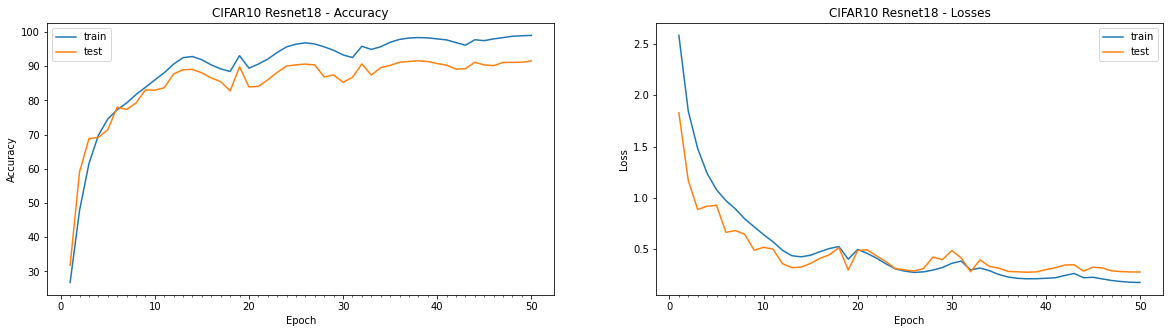

In [24]:
# Accurracy and loss history plot
model_history.plot_history(title=model_name)#, save_filename="model_history")

/content/gdrive/My Drive/TSAI_EVA_4.0/TSAI/utils/model_history.py:68: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs.set_xticks(np.arange(1,x_size+1),x_size/10)


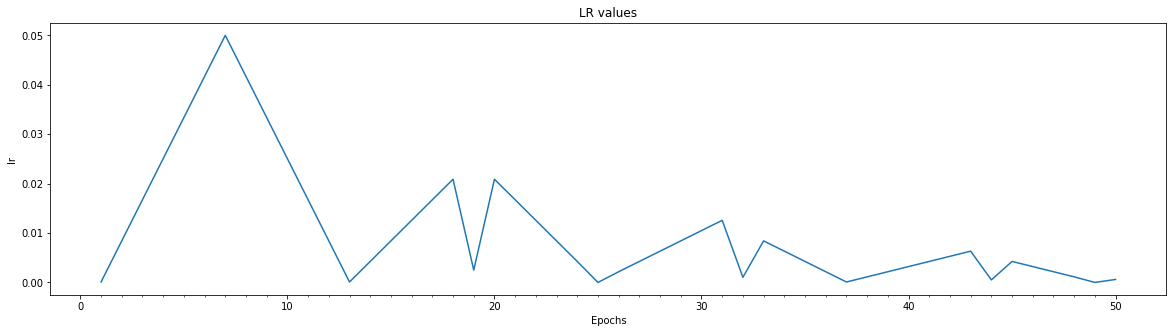

In [25]:
# Note: seriesname="val_acc", "val_loss", "train_acc", "train_loss", "lr"
model_history.plot_data_against_epoch("LR values", seriesname="lr")


Ploting misclassified images: CIFAR10 Resnet18



FileNotFoundError: ignored

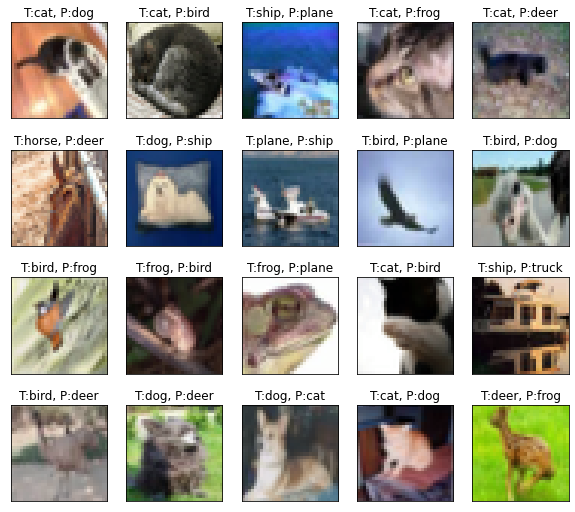

In [26]:
print("\nPloting misclassified images: {}\n".format(model_name))
putils.plot_misclassified_images(model, testloader=test_loader)#,save_filename="model_misclassified")

In [0]:
# create instance of GradCam module
config = dict(model_type='resnet', arch=model, layer_name='layer4')
gcam = gradcamAbs.GradCamAbs(device, config, means, stds)

In [28]:
gradcam_images, pred_results = gcam.applyOnMisclassifiedImages(dataloader=test_loader, num_of_images=25)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


FileNotFoundError: ignored

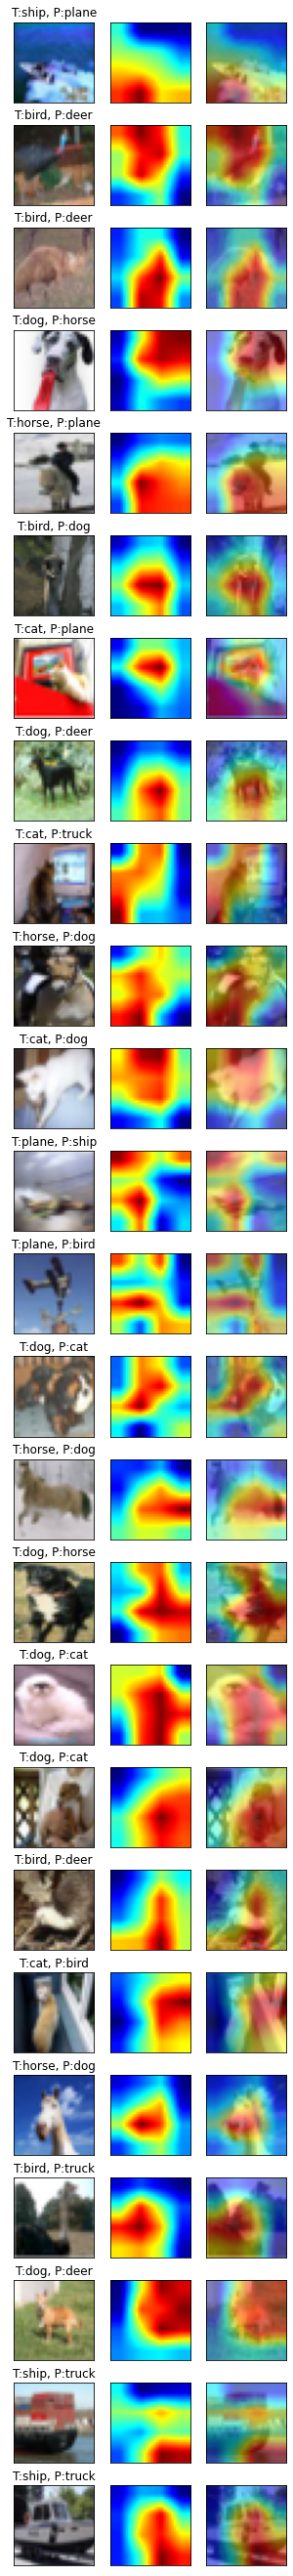

In [29]:
gcam.plot_results(gradcam_images, pred_results, classes, save_filename="gradcam_result_details")